In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Try to build a time series model in PyMC

In [2]:
import pymc as pm
import numpy as np

# Define the time points
T = 6
time = np.arange(T)

# Number of observations at each time point
n_obs = 10  # example number of observations per time point
Y = np.random.normal(0, 1, (n_obs, T))  # generate example data

In [3]:
with pm.Model() as model:
    # Priors for the initial standard deviation
    sigma_0 = pm.Exponential('sigma_0', 1.0)
    
    # Standard deviations for each time point
    sigmas = [sigma_0]
    
    for t in range(1, T):
        log_sigma_ratio = pm.Normal(f'log_sigma_ratio_{t}', mu=0, sigma=1)
        sigma_t = pm.Deterministic(f'sigma_{t}', sigmas[-1] * pm.math.exp(log_sigma_ratio))
        sigmas.append(sigma_t)
    
    # Convert list of sigmas to a tensor
    sigmas = pm.math.stack(sigmas)
    
    # Likelihood for the observations
    Y_obs = pm.Normal('Y_obs', mu=0, sigma=sigmas, observed=Y)

In [4]:
with model:
    trace = pm.sample(1000, return_inferencedata=True, nuts_sampler='nutpie')

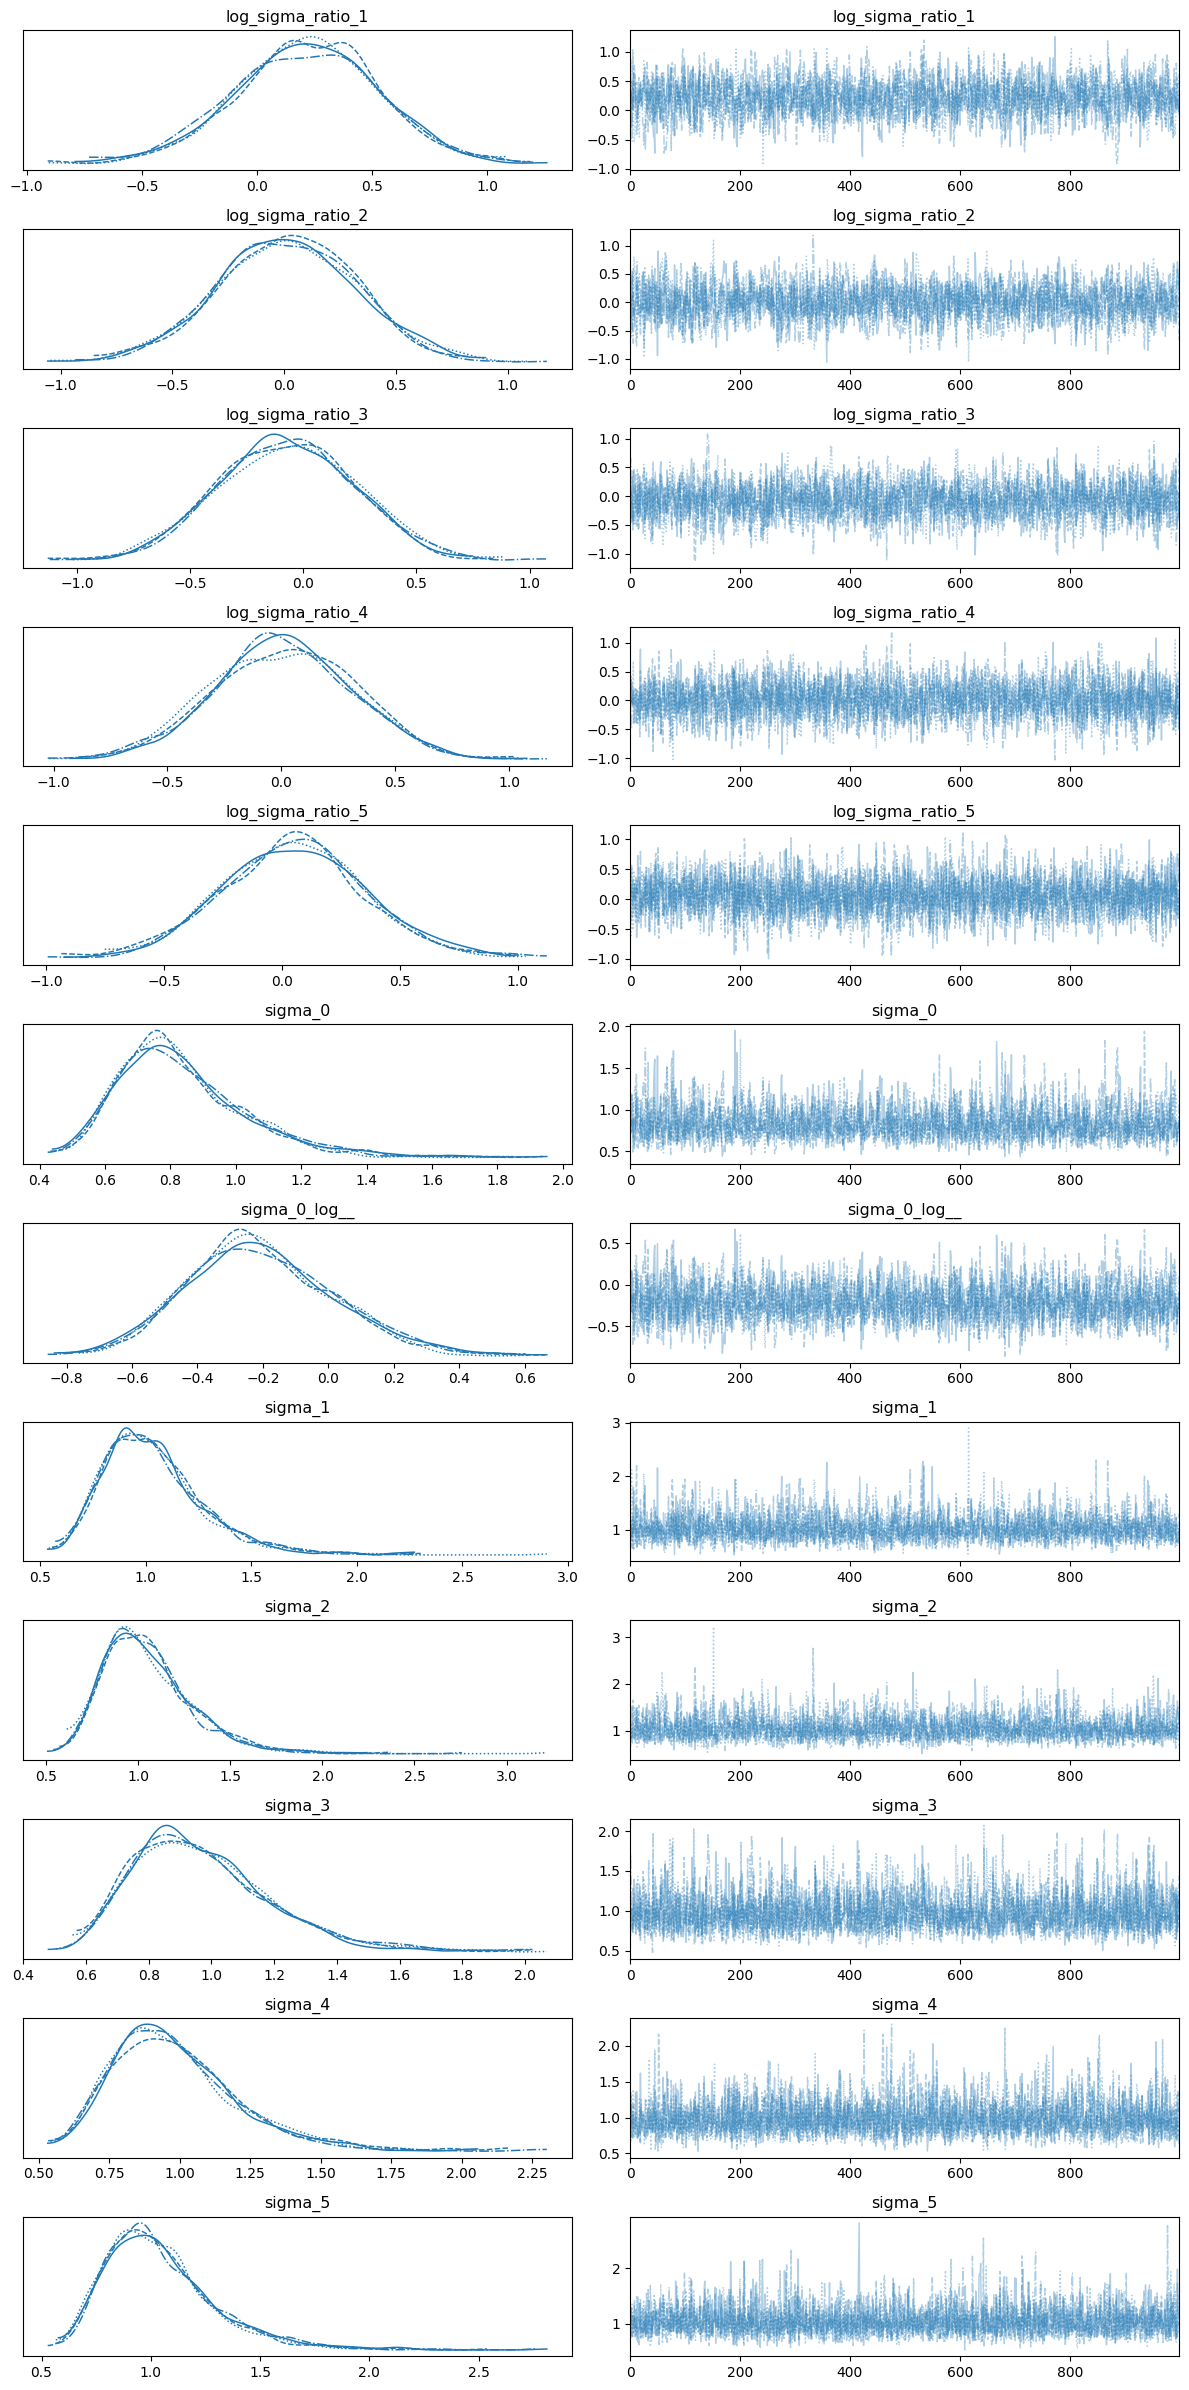

In [5]:
import arviz as az
import matplotlib.pyplot as plt

# Summarize the trace
az.summary(trace)

# Plot the posterior distributions
az.plot_trace(trace)

plt.tight_layout()

# Model with covariates

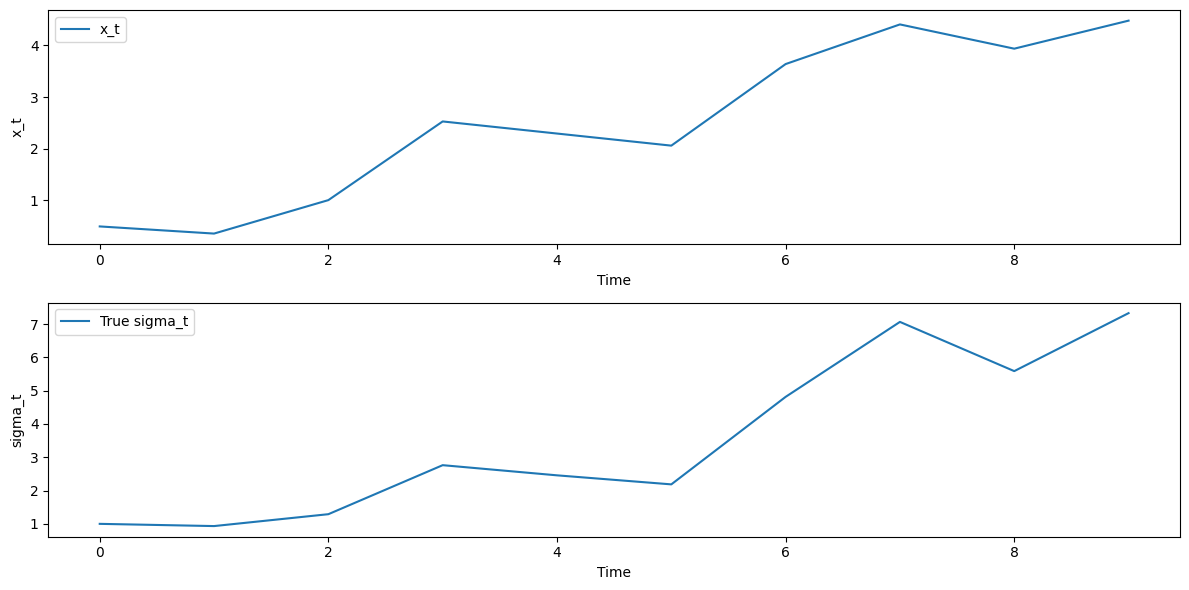

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time points
T = 10
time = np.arange(T)

# Generate covariate x_t
np.random.seed(42)
x = np.cumsum(np.random.normal(0, 1, T))

# True beta coefficient
beta_true = 0.5

# Generate standard deviations sigma_t
sigma_0 = 1.0
sigmas_true = [sigma_0]
for t in range(1, T):
    delta_x_t = x[t] - x[t-1]
    sigma_t = sigmas_true[-1] * np.exp(beta_true * delta_x_t)
    sigmas_true.append(sigma_t)

# Generate observations Y_it
n_obs = 64  # example number of observations per time point
Y = np.random.normal(0, sigmas_true, (n_obs, T))

# Plot the true sigma and covariate
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, x, label='x_t')
plt.xlabel('Time')
plt.ylabel('x_t')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, sigmas_true, label='True sigma_t')
plt.xlabel('Time')
plt.ylabel('sigma_t')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
import pymc as pm

with pm.Model() as model:
    # Priors for the initial standard deviation and beta
    sigma_0 = pm.Exponential('sigma_0', 1.0)
    beta_sigma = pm.Gamma('beta_sigma', alpha=1, beta=1)
    beta = pm.Normal('beta', mu=0, sigma=beta_sigma)
    
    # Standard deviations for each time point
    sigmas = [sigma_0]
    
    for t in range(1, T):
        delta_x_t = x[t] - x[t-1]
        sigma_t = pm.Deterministic(f'sigma_{t}', sigmas[-1] * pm.math.exp(beta * delta_x_t))
        sigmas.append(sigma_t)
    
    # Convert list of sigmas to a tensor
    sigmas = pm.math.stack(sigmas)
    
    # Likelihood for the observations
    Y_obs = pm.Normal('Y_obs', mu=0, sigma=sigmas, observed=Y)

In [11]:
with model:
    trace = pm.sample(1000, return_inferencedata=True, nuts_sampler='nutpie')

In [12]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.484,0.019,0.449,0.521,0.001,0.000,1397.0,1787.0,1.0
beta_sigma,0.899,0.700,0.174,2.142,0.015,0.010,2677.0,2520.0,1.0
beta_sigma_log__,-0.331,0.651,-1.516,0.865,0.013,0.009,2677.0,2520.0,1.0
sigma_0,1.019,0.049,0.925,1.108,0.001,0.001,1681.0,1820.0,1.0
sigma_0_log__,0.018,0.048,-0.075,0.106,0.001,0.001,1681.0,1820.0,1.0
sigma_1,0.953,0.048,0.860,1.040,0.001,0.001,1655.0,1828.0,1.0
sigma_2,1.304,0.053,1.207,1.405,0.001,0.001,1833.0,2073.0,1.0
sigma_3,2.726,0.077,2.581,2.870,0.001,0.001,4417.0,2814.0,1.0
sigma_4,2.434,0.070,2.301,2.562,0.001,0.001,3581.0,2895.0,1.0
sigma_5,2.173,0.065,2.054,2.295,0.001,0.001,2982.0,2835.0,1.0
